In [53]:
import os
import opyplus as op
import matplotlib.pyplot as plt
import pandas as pd
data_path = "../../data/sinergym/"
epw_files = os.listdir(data_path)
weather_dfs = []
base_df = None
for file in epw_files:
    # load weather data object
    try:
        if "USA" in file:
            weather_data = op.WeatherData.from_epw(os.path.join(data_path, file))
            weather_dfs.append(weather_data.get_weather_series())
            if file == 'USA_AZ_Davis-Monthan.AFB.722745_TMY3.epw':#'USA_NY_New.York-J.F.Kennedy.Intl.AP.744860_TMY3.epw':
            #if file == "USA_AZ_Tucson-Davis-Monthan.AFB.722745_TMYx.2007-2021.epw":
                base_df = weather_dfs[-1]
    except Exception as e:
        print(e)

not enough values to unpack (expected 10, got 1)
not enough values to unpack (expected 10, got 1)
not enough values to unpack (expected 10, got 1)
not enough values to unpack (expected 10, got 1)
not enough values to unpack (expected 10, got 1)
not enough values to unpack (expected 10, got 1)


In [57]:
base_df[1000:]

,year,month,day,hour,minute,datasource,drybulb,dewpoint,relhum,atmos_pressure,...,ceiling_hgt,presweathobs,presweathcodes,precip_wtr,aerosol_opt_depth,snowdepth,days_last_snow,Albedo,liq_precip_depth,liq_precip_rate
1000,2020,2,11,17,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,9.0,5.0,76.0,91720.0,...,1463.0,0.0,919999999,15.0,0.093,0.0,88.0,0.18,0.8,0.0
1001,2020,2,11,18,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,8.0,5.1,82.0,91778.0,...,1829.0,0.0,919999999,15.0,0.093,0.0,88.0,0.18,0.9,0.0
1002,2020,2,11,19,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,8.0,5.0,81.0,91778.0,...,1829.0,0.0,919999999,15.0,0.093,0.0,88.0,0.18,0.8,0.0
1003,2020,2,11,20,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,8.0,5.0,81.0,91869.0,...,1829.0,0.0,919999999,15.0,0.093,0.0,88.0,0.18,0.3,0.0
1004,2020,2,11,21,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,7.3,5.4,88.0,91910.0,...,2438.0,0.0,919999999,16.0,0.093,0.0,88.0,0.18,0.1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2014,12,31,20,NaN,?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9?9*9*9?9*9,5.0,4.0,93.0,91658.0,...,183.0,0.0,919999999,14.0,0.085,0.0,88.0,0.19,1.0,0.0
8756,2014,12,31,21,NaN,?9?9?9?9E0?9?9?9*9*9?9?9?9?9?9?9*9?9*9*9?9*9,4.0,4.0,100.0,91626.0,...,427.0,0.0,919999999,14.0,0.085,0.0,88.0,0.19,1.0,0.0
8757,2014,12,31,22,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,5.0,4.0,93.0,91658.0,...,12.0,0.0,919999999,14.0,0.085,0.0,88.0,0.21,1.1,0.0
8758,2014,12,31,23,NaN,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9*9?9*9*9?9*9,2.0,2.0,100.0,91559.0,...,152.0,0.0,919099999,11.0,0.085,0.0,88.0,0.24,1.2,0.0


In [51]:
import numpy as np
diffs = np.array(base_df["drybulb"])[1:] - np.array(base_df["drybulb"])[:-1]

a = pd.Series(diffs)
a.describe()

count    8759.000000
mean       -0.000445
std         0.962164
min        -5.000000
25%        -0.600000
50%         0.000000
75%         0.600000
max         7.000000
dtype: float64

### Overall Process of Embedding OU Parameters into a low dimensional space:
We model each weather file as having been generated from an OU process adding noise to the "base" weather of our environment. After recovering the OU parameters, we can encode them in a low dimensional space using PCA, which will capture the covariances between the parameters for each individual variable.

1. Subtract each epw from base epw and rescale using base epw's std deviation
2. Since OU process is auto-generative, we use a linear regression to predict the effect x[t] had on x[t+1]
3. Do some math on the linear regression outputs to recover the MLE of the OU process parameters for each variable for each epw
4. Standardize the recovered OU parameters
5. Fit PCA to the parameters

When generating new epw files:
1. Sample a uniform random variable and multiply it by the PCA
2. Rescale the new parameters by subtracting OU means and variances
3. Rescale again by multiplying OU offset and std parameters by the base epw's std deviation


In [2]:
variables = ['drybulb', 'relhum', "winddir", "dirnorrad", "difhorrad", "windspd", "precip_wtr"]#, "snowdepth"]
base_df = base_df[variables]
df_mean = base_df.mean(0)
df_std = base_df.std(0)
df_std[df_std == 0] = 1
dt = 1/8760

In [3]:
df_std

drybulb         9.689516
relhum         20.788645
winddir       105.638866
dirnorrad     253.598205
difhorrad      99.866677
windspd         2.467901
precip_wtr    113.602116
dtype: float64

In [4]:
for i in range(len(weather_dfs)):
    weather_dfs[i] = (weather_dfs[i][variables] - base_df) / (df_std + 0.0000001)

In [5]:
big_df = pd.concat(weather_dfs)
big_df.describe()

,drybulb,relhum,winddir,dirnorrad,difhorrad,windspd,precip_wtr
count,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07,1.294728e+07
mean,-7.160448e-02,-6.085656e-02,-1.333258e-01,9.089113e-02,-4.129070e-02,-4.388756e-01,-6.648374e-01
std,9.210296e-01,1.340783e+00,1.453158e+00,1.094890e+00,6.128332e-01,1.383258e+00,1.206316e+00
min,-6.594757e+00,-4.762215e+00,-3.407837e+00,-3.718481e+00,-5.557409e+00,-7.091047e+00,-4.480550e+00
25%,-6.398669e-01,-9.139605e-01,-1.135946e+00,0.000000e+00,-7.009345e-02,-1.256128e+00,-1.382017e+00
50%,-6.192260e-02,0.000000e+00,-9.466213e-02,0.000000e+00,0.000000e+00,-4.457229e-01,-6.073831e-01
75%,5.160217e-01,8.658573e-01,8.519592e-01,9.463789e-02,0.000000e+00,4.052027e-01,8.802653e-02
max,4.809322e+00,4.281183e+00,3.407837e+00,5.587579e+00,5.437249e+00,2.791846e+01,4.850262e+00


In [6]:
weather_dfs[0].shape

(8760, 7)

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np
OU_vars = {k: [] for k in weather_dfs[0].columns}
all_OU = []
scores = {k: [] for k in weather_dfs[0].columns}
all_scores = []
coefs = []
intercepts = []
for i in range(len(weather_dfs)):
    if np.any(weather_dfs[i].isna()):
        continue
    for j in range(weather_dfs[i].shape[-1]):
        reg = LinearRegression()
        split = int(8760 * 0.8)
        X_train = np.array(weather_dfs[i].iloc[:split-1, j]).reshape([-1, 1])
        y_train = np.array(weather_dfs[i].iloc[1:split, j]).reshape([-1, 1])
        X_test = np.array(weather_dfs[i].iloc[split:-1, j]).reshape([-1, 1])
        y_test = np.array(weather_dfs[i].iloc[split+1:, j]).reshape([-1, 1])
        reg = reg.fit(X_train, y_train)
        preds = reg.predict(X_train)
        std = np.sqrt(np.mean((preds - y_train) ** 2))
        score = reg.score(X_test, y_test)
        scores[weather_dfs[i].columns[j]].append(score)
        coef = reg.coef_.squeeze().item()
        coefs.append(coef)
        intercept = reg.intercept_.squeeze().item()
        intercepts.append(intercept)
        if coef == 0:
            tau = 0.001
        else:
            tau = dt / (1 - coef) #(1 - dt) / coef
        mu = intercept * tau / dt
        sigma = std / (np.sqrt(dt * 2. / tau))

        OU_vars[weather_dfs[i].columns[j]].append(np.array([sigma, mu, tau]))
        all_OU.append(np.array([sigma, mu, tau]))
        all_scores.append(score)

In [8]:
all_OU = np.stack(all_OU)
all_scores = np.stack(all_scores)

In [9]:
pd.DataFrame(all_scores).describe()

,0
count,10346.000000
mean,0.727050
std,0.231331
min,0.015572
25%,0.537159
50%,0.738348
75%,0.951487
max,1.000000


In [10]:
{k: np.mean(np.array(var), axis=0) for k, var in OU_vars.items()}

{'drybulb': array([ 0.68048508, -0.05891798,  0.00575459]),
 'relhum': array([ 1.24351845, -0.11622733,  0.00278508]),
 'winddir': array([ 1.28718006e+00, -5.30000615e-02,  3.72765065e-04]),
 'dirnorrad': array([1.05266948e+00, 9.44742432e-02, 6.56054318e-04]),
 'difhorrad': array([ 5.86423264e-01, -4.11938079e-02,  3.46981015e-04]),
 'windspd': array([ 1.19433483e+00, -3.80312654e-01,  6.74827466e-04]),
 'precip_wtr': array([ 0.85084864, -0.7757273 ,  0.03886508])}

In [11]:
import os, sys
dir = os.path.abspath('../../')
if not dir in sys.path: sys.path.append(dir)
from core.utils import *
# add in default weather variability config
weather_var_names = ['drybulb', 'relhum',
                        "winddir", "dirnorrad", "difhorrad"]
weather_var_rev_names = ["windspd"]

# We only need to include the default evaluation variability since we'll sample the rest later

weather_variabilities = build_variability_dict(weather_var_names, weather_var_rev_names, (1., 0., 0.001))
for i, key in enumerate(variables):
    if key in weather_variabilities:
        scaled_variability = np.array(weather_variabilities[key])
        #scaled_variability[:2] /= df_std[i]
        OU_vars[key] = [scaled_variability] + OU_vars[key]
    else:
        OU_vars[key] = [np.array([0, 0, 0.001])] + OU_vars[key]

In [52]:
df_std

drybulb         9.689516
relhum         20.788645
winddir       105.638866
dirnorrad     253.598205
difhorrad      99.866677
windspd         2.467901
precip_wtr    113.602116
dtype: float64

In [12]:
OU_vars = {k: np.stack(v) for k, v in OU_vars.items()}

In [13]:
OU_vars

{'drybulb': array([[ 0.10320433,  0.        ,  0.001     ],
        [ 0.72809948, -0.92434893,  0.00922557],
        [ 0.74361934, -0.95178767,  0.00975655],
        ...,
        [ 0.70693559,  0.2980265 ,  0.0072586 ],
        [ 0.66297496,  0.30546955,  0.00579554],
        [ 0.66578782,  0.55372757,  0.00579127]]),
 'relhum': array([[ 4.81031837e-02,  0.00000000e+00,  1.00000000e-03],
        [ 1.08817282e+00,  6.44548873e-01,  1.98388060e-03],
        [ 1.27641529e+00,  3.12173420e-01,  2.63898593e-03],
        ...,
        [ 1.23941883e+00,  4.67465292e-02,  3.06642065e-03],
        [ 1.18791890e+00,  4.58352896e-02,  2.51444873e-03],
        [ 1.16387258e+00, -1.29800744e-02,  2.36772654e-03]]),
 'winddir': array([[ 9.46621293e-03,  0.00000000e+00,  1.00000000e-03],
        [ 1.26226008e+00,  7.65417772e-02,  4.05620898e-04],
        [ 1.34279782e+00,  3.01914928e-02,  4.25358522e-04],
        ...,
        [ 1.26261010e+00, -1.96639442e-01,  3.35678851e-04],
        [ 1.24449553e

In [14]:
from scipy import stats
from copy import deepcopy
from sklearn.model_selection import train_test_split
OU_dict = {}
for i in range(len(OU_vars["drybulb"])):
    for j, var in enumerate(variables):
        for k in range(3):
            OU_dict[f"{var}_{k}"] = OU_vars[var][:, k]
OU_df = pd.DataFrame.from_dict(OU_dict)
# OU_df = OU_df[(np.abs(stats.zscore(OU_df)) < 3).all(axis=1)]
OU_df_saved = deepcopy(OU_df)
OU_mean = OU_df.mean(axis=0)
OU_std = OU_df.std(axis=0)
OU_df = (OU_df - OU_df.mean(axis=0)) / (OU_df.std(axis=0))
OU_df_train, OU_df_test = train_test_split(OU_df, test_size=0.2)

In [15]:
OU_vars

{'drybulb': array([[ 0.10320433,  0.        ,  0.001     ],
        [ 0.72809948, -0.92434893,  0.00922557],
        [ 0.74361934, -0.95178767,  0.00975655],
        ...,
        [ 0.70693559,  0.2980265 ,  0.0072586 ],
        [ 0.66297496,  0.30546955,  0.00579554],
        [ 0.66578782,  0.55372757,  0.00579127]]),
 'relhum': array([[ 4.81031837e-02,  0.00000000e+00,  1.00000000e-03],
        [ 1.08817282e+00,  6.44548873e-01,  1.98388060e-03],
        [ 1.27641529e+00,  3.12173420e-01,  2.63898593e-03],
        ...,
        [ 1.23941883e+00,  4.67465292e-02,  3.06642065e-03],
        [ 1.18791890e+00,  4.58352896e-02,  2.51444873e-03],
        [ 1.16387258e+00, -1.29800744e-02,  2.36772654e-03]]),
 'winddir': array([[ 9.46621293e-03,  0.00000000e+00,  1.00000000e-03],
        [ 1.26226008e+00,  7.65417772e-02,  4.05620898e-04],
        [ 1.34279782e+00,  3.01914928e-02,  4.25358522e-04],
        ...,
        [ 1.26261010e+00, -1.96639442e-01,  3.35678851e-04],
        [ 1.24449553e

In [16]:
OU_mean

drybulb_0       0.680095
drybulb_1      -0.058878
drybulb_2       0.005751
relhum_0        1.242710
relhum_1       -0.116149
relhum_2        0.002784
winddir_0       1.286316
winddir_1      -0.052964
winddir_2       0.000373
dirnorrad_0     1.051960
dirnorrad_1     0.094410
dirnorrad_2     0.000656
difhorrad_0     0.586034
difhorrad_1    -0.041166
difhorrad_2     0.000347
windspd_0       1.193801
windspd_1      -0.380056
windspd_2       0.000675
precip_wtr_0    0.850273
precip_wtr_1   -0.775203
precip_wtr_2    0.038839
dtype: float64

In [17]:
OU_std

drybulb_0       0.082185
drybulb_1       0.573955
drybulb_2       0.002094
relhum_0        0.112415
relhum_1        0.499962
relhum_2        0.000514
winddir_0       0.084830
winddir_1       0.237867
winddir_2       0.000064
dirnorrad_0     0.073617
dirnorrad_1     0.198585
dirnorrad_2     0.000082
difhorrad_0     0.061988
difhorrad_1     0.089540
difhorrad_2     0.000072
windspd_0       0.142157
windspd_1       0.404151
windspd_2       0.000147
precip_wtr_0    0.102040
precip_wtr_1    0.938158
precip_wtr_2    0.024787
dtype: float64

In [18]:

for i, column in enumerate(OU_df_saved.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        OU_df_saved.iloc[:, i] *= df_std[i//3]
OU_df_saved.to_csv("US_epw_OU_params.csv", index=False) 

In [19]:
OU_df.shape
# df_std.shape

(1479, 21)

In [20]:
from sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from sklearn.manifold import TSNE
import umap
pca = PCA(2)
# pca = KernelPCA(2, kernel="poly", degree=2, fit_inverse_transform=True, alpha=1)
# pca = umap.UMAP(n_components=2, n_neighbors=400)
pca.fit(OU_df)
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed_train = pd.DataFrame(pca.transform(OU_df_train))
y = OU_df_test.to_numpy()
y_train = OU_df_train.to_numpy()

2023-03-06 17:52:15.544769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 17:52:15.741372: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 17:52:15.771662: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.5/lib64:/home/doseok/.mujoco/mujoco200/bin/
2023-03-06 17:52:15.

In [21]:
all_transformed = pd.DataFrame(pca.transform(OU_df))
transformed = pd.DataFrame(pca.transform(OU_df_test))
transformed.describe()

,0,1
count,296.000000,296.000000
mean,0.265440,-0.269845
std,2.152020,1.841081
min,-7.671303,-4.681654
25%,-1.043502,-1.352040
50%,0.578528,-0.441805
75%,1.960369,0.845495
max,4.358958,5.725039


In [22]:
idx = np.abs(all_transformed[0].to_numpy()) > 2
weird_vals = OU_df[idx]

In [23]:
weird_vals

,drybulb_0,drybulb_1,drybulb_2,relhum_0,relhum_1,relhum_2,winddir_0,winddir_1,winddir_2,dirnorrad_0,...,dirnorrad_2,difhorrad_0,difhorrad_1,difhorrad_2,windspd_0,windspd_1,windspd_2,precip_wtr_0,precip_wtr_1,precip_wtr_2
0,-7.019433,0.102583,-2.268964,-10.626804,0.232315,-3.471750,-15.051896,0.222663,9.858471,-14.236097,...,4.209676,-9.292385,0.459750,9.125432,-5.547396,0.940381,2.217993,-8.332772,0.826303,-1.526589
14,-0.574526,-0.768099,-0.746280,0.650118,-1.814364,0.033203,-0.393631,0.218753,-1.605759,0.250859,...,-0.307194,0.662216,-0.500622,0.611808,0.427915,-0.430914,-0.705363,0.975689,-1.260124,1.399556
16,-0.403757,-0.726160,-1.252430,1.175622,-1.479448,-0.906049,0.067928,0.430335,-0.453912,1.426150,...,-1.843430,1.284020,-1.253579,0.516912,2.906529,1.454971,-0.538034,-0.595805,-0.441643,-0.268836
17,0.168773,-0.618173,-0.889716,2.156371,-1.553734,0.661764,0.828900,0.301169,-1.254338,1.888792,...,-1.024278,0.871257,-1.248137,-0.108643,0.718909,0.024617,-1.256717,0.004724,-0.398223,-0.199496
18,-0.622305,-1.033871,-0.490721,1.683309,-1.555308,2.349254,-1.142258,0.837358,-0.016267,-0.076507,...,-0.555682,0.436455,-0.755614,0.991103,1.504179,1.304891,0.529695,1.063567,-1.245508,1.422103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,-0.546853,0.685674,0.050880,0.051841,0.240204,0.441833,0.803349,-0.699018,-0.244957,-1.263915,...,-2.117077,-0.739009,0.500783,-1.230941,-0.880576,-1.166318,-0.772259,-1.244045,1.303554,-0.629996
1472,-0.718925,0.888284,-0.799240,-0.642562,0.309923,-1.028742,0.327908,-1.491944,-0.739152,-0.481052,...,-0.675308,-0.567588,1.421622,-0.649365,-0.741874,-0.940879,-0.943037,-0.591207,1.155165,-1.036849
1474,-0.590706,0.989076,-0.560210,0.074975,0.839475,-0.341001,0.093572,0.113054,0.168775,-0.729744,...,-0.525977,0.076796,1.667564,-1.233224,-0.999862,-1.050738,-0.372273,-0.015905,1.642769,-0.426060
1475,-0.113485,0.664826,-0.438109,-0.935395,0.571003,-0.901347,0.665067,-2.145957,-0.930145,-0.295007,...,-0.735681,-0.744524,0.790535,-1.215015,-0.792908,-1.837354,-0.834771,0.725346,1.309315,-0.619521


In [24]:
all_transformed.iloc[0]

0     8.996174
1    13.086063
Name: 0, dtype: float64

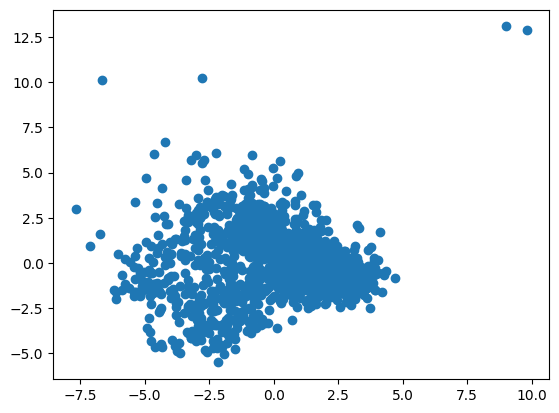

In [25]:
plt.scatter(all_transformed.iloc[:, 0], all_transformed.iloc[:, 1])

In [26]:
OU_df_saved.iloc[0]

drybulb_0       1.000
drybulb_1       0.000
drybulb_2       0.001
relhum_0        1.000
relhum_1        0.000
relhum_2        0.001
winddir_0       1.000
winddir_1       0.000
winddir_2       0.001
dirnorrad_0     1.000
dirnorrad_1     0.000
dirnorrad_2     0.001
difhorrad_0     1.000
difhorrad_1     0.000
difhorrad_2     0.001
windspd_0       1.000
windspd_1      -0.000
windspd_2       0.001
precip_wtr_0    0.000
precip_wtr_1    0.000
precip_wtr_2    0.001
Name: 0, dtype: float64

In [27]:
OU_mean

drybulb_0       0.680095
drybulb_1      -0.058878
drybulb_2       0.005751
relhum_0        1.242710
relhum_1       -0.116149
relhum_2        0.002784
winddir_0       1.286316
winddir_1      -0.052964
winddir_2       0.000373
dirnorrad_0     1.051960
dirnorrad_1     0.094410
dirnorrad_2     0.000656
difhorrad_0     0.586034
difhorrad_1    -0.041166
difhorrad_2     0.000347
windspd_0       1.193801
windspd_1      -0.380056
windspd_2       0.000675
precip_wtr_0    0.850273
precip_wtr_1   -0.775203
precip_wtr_2    0.038839
dtype: float64

In [28]:
# sample = np.random.uniform(-0.5, 0, [1, 3])
sample = np.array([[-0.3, -0.3]])
sampled_OU_vars = pca.inverse_transform(sample)
sampled_OU_vars = sampled_OU_vars * np.array(OU_std)[None, -1] + np.array(OU_mean)[None, -1]
store_OU_mean = deepcopy(OU_mean)
store_OU_std = deepcopy(OU_std)
for i, column in enumerate(OU_df.columns):
    delim_idx = column.rfind("_")
    var = column[:delim_idx]
    idx = int(column[delim_idx+1:])
    if idx in [0, 1]:
        sampled_OU_vars[:, i] *= df_std[i//3]
        store_OU_mean[i] *= df_std[i//3]
        store_OU_std[i] *= df_std[i//3]


In [29]:
store_OU_mean

drybulb_0         6.589789
drybulb_1        -0.570501
drybulb_2         0.005751
relhum_0         25.834261
relhum_1         -2.414575
relhum_2          0.002784
winddir_0       135.884980
winddir_1        -5.595081
winddir_2         0.000373
dirnorrad_0     266.775270
dirnorrad_1      23.942299
dirnorrad_2       0.000656
difhorrad_0      58.525222
difhorrad_1      -4.111107
difhorrad_2       0.000347
windspd_0         2.946183
windspd_1        -0.937939
windspd_2         0.000675
precip_wtr_0     96.592853
precip_wtr_1    -88.064679
precip_wtr_2      0.038839
dtype: float64

In [30]:
from importlib import reload
import epw_data
from epw_data import EPW_Data
reload(epw_data)

import pickle
epw_data_ = epw_data.EPW_Data(OU_df_saved, all_transformed, pca, store_OU_mean, store_OU_std)
epw_data_.save("US_epw_OU_data_test.pkl")
# with open("US_epw_OU_data.pkl", 'wb') as f:
#     pickle.dump(epw_data_, f)

In [31]:
loaded_data = epw_data.EPW_Data.load("US_epw_OU_data.pkl")
# with open("US_epw_OU_data.pkl", 'rb') as f:
#     loaded_data = pickle.load(f)

In [32]:
loaded_data.OU_mean

drybulb_0         6.589789
drybulb_1        -0.570501
drybulb_2         0.005751
relhum_0         25.834261
relhum_1         -2.414575
relhum_2          0.002784
winddir_0       135.884980
winddir_1        -5.595081
winddir_2         0.000373
dirnorrad_0     266.775270
dirnorrad_1      23.942299
dirnorrad_2       0.000656
difhorrad_0      58.525222
difhorrad_1      -4.111107
difhorrad_2       0.000347
windspd_0         2.946183
windspd_1        -0.937939
windspd_2         0.000675
precip_wtr_0     96.592853
precip_wtr_1    -88.064679
precip_wtr_2      0.038839
dtype: float64

In [33]:
loaded_data.read_OU_param(loaded_data.OU_mean, "precip_wtr")

array([ 9.65928529e+01, -8.80646787e+01,  3.88394746e-02])